In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow, suppresses logs

import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np


import re
from typing import Dict, List, Optional, Text, Tuple
from matplotlib import colors

import tensorflow as tf
import numpy as np


from tqdm import tqdm
from typing import Callable, Tuple

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss


import keras_tuner as kt


In [2]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [3]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

In [4]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)
    
    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]
  
    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:

parsed_dataset = get_dataset('../data_collection/next_day_dataset/*tfrecord', 
    data_size=64, sample_size=32,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

non_cropped_datatset = get_dataset('../data_collection/next_day_dataset/*tfrecord', 
    data_size=64, sample_size=32,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=False, center_crop=False)


length = sum(1 for _ in parsed_dataset)

shuffled_dataset = parsed_dataset.shuffle(buffer_size=length, reshuffle_each_iteration=False)

# Define split sizes
train_size = int(0.8 * length)
val_size = int(0.1 * length)

# Split the dataset
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size).take(val_size)
test_dataset = shuffled_dataset.skip(train_size + val_size)



batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(1)





In [6]:

print(f"Dataset length: {length}")

Dataset length: 18545


In [7]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [8]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.
    
    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES
    
    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break
    
    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
            plt.axis('off')
    plt.tight_layout()
    

In [9]:
for i, j in train_dataset.take(10):
    print(i.dtype)
    print(np.unique(i[0, :, :, 11].numpy()))

<dtype: 'float32'>
[0. 1.]
<dtype: 'float32'>
[0.]
<dtype: 'float32'>
[0.]
<dtype: 'float32'>
[0. 1.]
<dtype: 'float32'>
[-1.  0.  1.]
<dtype: 'float32'>
[0. 1.]
<dtype: 'float32'>
[0.]
<dtype: 'float32'>
[0. 1.]
<dtype: 'float32'>
[0.]
<dtype: 'float32'>
[0. 1.]


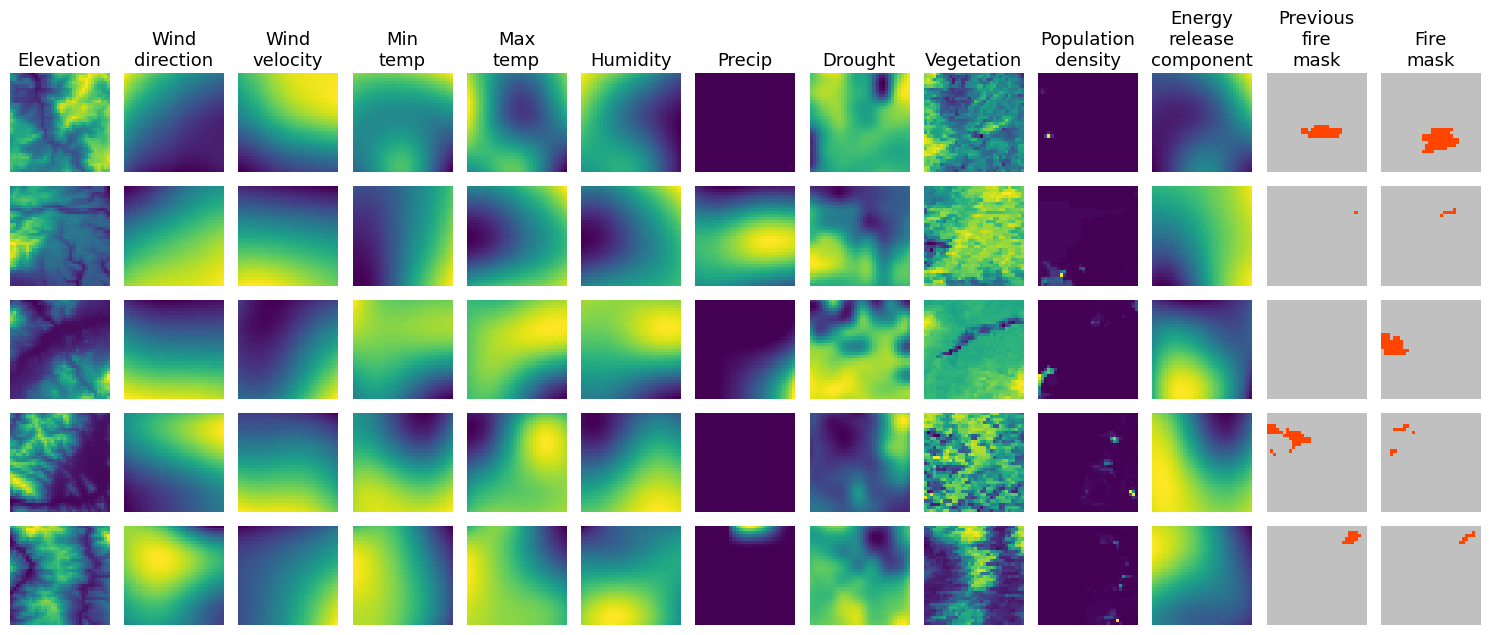

In [ ]:
plot_samples_from_dataset(non_cropped_datatset, 5)

## Model Building

In [11]:
#Residual Block

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, mode='conv', filters=32, kernel_size=3, dropout=.1):
        super(ResidualBlock, self).__init__()
        self.leaky1 = tf.keras.layers.LeakyReLU(.1)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.center = tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same') if mode == 'conv' else tf.keras.layers.MaxPool2D()
        self.leaky2 = tf.keras.layers.LeakyReLU(.1)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')
        self.dropout3 = tf.keras.layers.Dropout(dropout)

        self.convskip = tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same')
        self.dropoutskip = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        main = self.leaky1(inputs)
        main = self.dropout1(main, training=training)
        main = self.center(main)
        main = self.leaky2(main)
        main = self.dropout2(main, training=training)
        main = self.conv1(main)
        main = self.dropout3(main, training=training)

        skip = self.convskip(inputs)
        skip = self.dropoutskip(skip, training=training)

        return skip + main









# Basic Model (Paper)

def build_basic_model():

    inp = tf.keras.layers.Input(shape=[32, 32, 11])

    x = inp

    conv1 = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same')(x)
    leaky1 = tf.keras.layers.LeakyReLU(.1)(conv1)
    dropout1 = tf.keras.layers.Dropout(.1)(leaky1)
    conv2 = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same')(dropout1)




    conv_skip = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same')(x)
    dropout_skip = tf.keras.layers.Dropout(.1)(conv_skip)

    add1 = conv2 + dropout_skip

    res1 = ResidualBlock(mode='max')(add1)
    res2 = ResidualBlock(mode='max')(res1)

    convt1 = tf.keras.layers.Conv2DTranspose(16, 3, strides=4, padding='same')(res2)
    res3 = ResidualBlock(mode='conv')(convt1)
    convt2 = tf.keras.layers.Conv2DTranspose(16, 3, strides=4, padding='same')(res3)
    res4 = ResidualBlock(mode='conv')(convt2)
    conv3 = tf.keras.layers.Conv2D(1, 3, strides=1, padding='same', activation='sigmoid')(res4)


    return tf.keras.Model(inputs=inp, outputs=conv3)

build_basic_model().summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 11)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1600        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 16)   0           ['leaky_re_lu[0][0]']        

In [12]:

def binary_crossentropy(y_true, y_pred):
    """
    Binary cross-entropy with masking and class weighting for positive cases.

    Args:
        y_true: Ground truth tensor, where -1 represents masked values.
        y_pred: Predicted probabilities tensor.
        positive_weight: Weight assigned to positive cases (y_true == 1).

    Returns:
        Weighted binary cross-entropy loss with masking.
    """
    # Mask invalid values (where y_true == -1)
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)

    # Weight for positive and negative cases
    weights = tf.where(y_true == 1, 4.0, 1.0)

    # Compute binary cross-entropy
    bce = K.binary_crossentropy(y_true * mask, y_pred * mask)

    # Apply weights to the loss
    weighted_bce = bce * weights

    # Return the mean loss, considering the mask
    return tf.reduce_sum(weighted_bce) / tf.reduce_sum(mask)




def build_model_with_hyperparameters(hp):

    global_filters = hp.Choice('filters_1', values=[16, 32, 64])
    global_kernel_size = hp.Choice('kernel_size_1', values=[3, 5])
    global_dropout = hp.Float('dropout_1', 0.1, 0.5, step=0.1)


    inp = tf.keras.layers.Input(shape=[32, 32, 12])

    x = inp

    # First convolutional layer with tunable filters
    conv1 = tf.keras.layers.Conv2D(
        filters=global_filters,
        kernel_size=global_kernel_size,
        strides=1,
        padding='same'
    )(x)
    leaky1 = tf.keras.layers.LeakyReLU(0.1)(conv1)
    dropout1 = tf.keras.layers.Dropout(global_dropout)(leaky1)
    conv2 = tf.keras.layers.Conv2D(
        filters=global_filters,
        kernel_size=3,
        strides=1,
        padding='same'
    )(dropout1)

    # Skip connection
    conv_skip = tf.keras.layers.Conv2D(
        filters=global_filters, 
        kernel_size=global_kernel_size,
        strides=1,
        padding='same'
        )(x)
    dropout_skip = tf.keras.layers.Dropout(global_dropout)(conv_skip)

    add1 = conv2 + dropout_skip

    # Residual blocks
    res1 = ResidualBlock(mode='max', filters=global_filters, kernel_size=global_kernel_size, dropout=global_dropout)(add1)
    res2 = ResidualBlock(mode='max', filters=global_filters, kernel_size=global_kernel_size, dropout=global_dropout)(res1)

    # Transposed convolutions
    convt1 = tf.keras.layers.Conv2DTranspose(
        filters=global_filters,
        kernel_size=global_kernel_size,
        strides=4,
        padding='same'
    )(res2)

    res3 = ResidualBlock(mode='conv', filters=global_filters, kernel_size=global_kernel_size, dropout=global_dropout)(convt1)
    convt2 = tf.keras.layers.Conv2DTranspose(16, 3, strides=4, padding='same')(res3)
    res4 = ResidualBlock(mode='conv', filters=global_filters, kernel_size=global_kernel_size, dropout=global_dropout)(convt2)

    # Final convolution layer
    conv3 = tf.keras.layers.Conv2D(1, global_kernel_size, strides=1, padding='same', activation='sigmoid')(res4)

    # Compile model with tunable learning rate
    model = tf.keras.Model(inputs=inp, outputs=conv3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])
        ),
        loss=binary_crossentropy,  # Binary cross-entropy loss
        metrics=[binary_crossentropy]  # Use appropriate metrics
    )
    return model




In [13]:
tuner = kt.Hyperband(
    build_model_with_hyperparameters,
    objective='val_binary_crossentropy',  # Optimize for validation MSE
    max_epochs=50,
    factor=3,
    directory='filter_tuning_test',
    project_name='basic_model'
)

# Perform the search
tuner.search(
    train_dataset,  # Replace with your training dataset
    validation_data=val_dataset,  # Replace with your validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=5)]
)


Trial 30 Complete [00h 01m 57s]
val_binary_crossentropy: 0.22774918377399445

Best val_binary_crossentropy So Far: 0.2091018706560135
Total elapsed time: 00h 34m 33s


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=10)
for h in best_hps:
    print(h.values)

{'filters_1': 64, 'kernel_size_1': 5, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}
{'filters_1': 32, 'kernel_size_1': 3, 'dropout_1': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
{'filters_1': 16, 'kernel_size_1': 3, 'dropout_1': 0.1, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
{'filters_1': 32, 'kernel_size_1': 5, 'dropout_1': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0018'}
{'filters_1': 64, 'kernel_size_1': 5, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.0001, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0000'}
{'filters_1': 64,

In [15]:
top_models = tuner.get_best_models(num_models=10)

# Train each model for 50 epochs and collect their histories
#histories = []
#for i, model in enumerate(top_models):
#    print(f"Training Model {i+1}")
#    history = model.fit(
#        train_dataset,  # Replace with your training dataset
#        validation_data=val_dataset,  # Replace with your validation dataset
#        epochs=50,
#        verbose=1, # Set to 0 for silent training
#        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=3)]  
#    )
#    histories.append(history)


In [16]:

# Plot the accuracy metrics for each model
plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    # Plot training and validation accuracy
    #plt.plot(history.history['loss'], label=f'Model {i+1} - Training')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'Model {i+1} - Validation')

# Customize the plot
plt.title('Validation Accuracy of Top 10 Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

NameError: name 'histories' is not defined

<Figure size 1200x800 with 0 Axes>

In [17]:

class InceptionBlock(tf.keras.layers.Layer):
    def __init__(self, filters=32, dropout=0.1):
        super(InceptionBlock, self).__init__()
        # Branch 1: 1x1 Convolution
        self.branch1x1 = tf.keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same', activation='relu')
        self.branch1x1_dropout = tf.keras.layers.Dropout(dropout)

        # Branch 2: 3x3 Convolution
        self.branch3x3_reduce = tf.keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same', activation='relu')
        self.branch3x3 = tf.keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same', activation='relu')
        self.branch3x3_dropout = tf.keras.layers.Dropout(dropout)

        # Branch 3: 5x5 Convolution
        self.branch5x5_reduce = tf.keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same', activation='relu')
        self.branch5x5 = tf.keras.layers.Conv2D(filters, (5, 5), strides=1, padding='same', activation='relu')
        self.branch5x5_dropout = tf.keras.layers.Dropout(dropout)

        # Branch 4: Pooling + 1x1 Convolution
        self.branch_pool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')
        self.branch_pool_proj = tf.keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same', activation='relu')
        self.branch_pool_dropout = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        # Branch 1: 1x1 Convolution
        branch1 = self.branch1x1(inputs)
        branch1 = self.branch1x1_dropout(branch1, training=training)

        # Branch 2: 3x3 Convolution
        branch2 = self.branch3x3_reduce(inputs)
        branch2 = self.branch3x3(branch2)
        branch2 = self.branch3x3_dropout(branch2, training=training)

        # Branch 3: 5x5 Convolution
        branch3 = self.branch5x5_reduce(inputs)
        branch3 = self.branch5x5(branch3)
        branch3 = self.branch5x5_dropout(branch3, training=training)

        # Branch 4: Pooling + 1x1 Convolution
        branch4 = self.branch_pool(inputs)
        branch4 = self.branch_pool_proj(branch4)
        branch4 = self.branch_pool_dropout(branch4, training=training)

        # Concatenate all branches along the channel dimension
        output = tf.keras.layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
        return output




def build_inception_model():
    inp = tf.keras.layers.Input(shape=[32, 32, 12])

    x = inp

    conv1 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(x)
    leaky1 = tf.keras.layers.LeakyReLU(.1)(conv1)
    dropout1 = tf.keras.layers.Dropout(.1)(leaky1)
    conv2 = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same')(dropout1)


    inc1 = InceptionBlock(filters=32, dropout=.1)(conv2)
    inc2 = InceptionBlock(filters=32, dropout=.1)(inc1)


    convt1 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(inc2)
    convt2 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(convt1)
    conv3 = tf.keras.layers.Conv2D(1, 3, strides=1, padding='same', activation='sigmoid')(convt2)


    return tf.keras.Model(inputs=inp, outputs=conv3)

build_inception_model().summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 12)]      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 32)        3488      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 inception_block (InceptionB  (None, 8, 8, 128)        39104     
 lock)                                                           
                                                           

In [18]:
def build_inception_with_hyperparameters(hp):

    global_filters = hp.Choice('filters_1', values=[16, 32, 64])
    global_kernel_size = hp.Choice('kernel_size_1', values=[3, 5])
    global_dropout = hp.Float('dropout_1', 0.1, 0.5, step=0.1)


    inp = tf.keras.layers.Input(shape=[32, 32, 12])

    x = inp

    conv1 = tf.keras.layers.Conv2D(global_filters, global_kernel_size, strides=2, padding='same')(x)
    leaky1 = tf.keras.layers.LeakyReLU(.1)(conv1)
    dropout1 = tf.keras.layers.Dropout(global_dropout)(leaky1)
    conv2 = tf.keras.layers.Conv2D(global_filters, global_kernel_size, strides=2, padding='same')(dropout1)


    inc1 = InceptionBlock(filters=global_kernel_size, dropout=global_dropout)(conv2)
    inc2 = InceptionBlock(filters=global_kernel_size, dropout=global_dropout)(inc1)


    convt1 = tf.keras.layers.Conv2DTranspose(global_filters, global_kernel_size, strides=2, padding='same')(inc2)
    convt2 = tf.keras.layers.Conv2DTranspose(global_filters, global_kernel_size, strides=2, padding='same')(convt1)
    conv3 = tf.keras.layers.Conv2D(1, global_kernel_size, strides=1, padding='same', activation='sigmoid')(convt2)

    # Compile model with tunable learning rate
    model = tf.keras.Model(inputs=inp, outputs=conv3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])
        ),
        loss=binary_crossentropy,  # Binary cross-entropy loss
        metrics=[binary_crossentropy]  # Use appropriate metrics
    )
    return model

In [19]:
tuner_inception = kt.Hyperband(
    build_inception_with_hyperparameters,
    objective='val_binary_crossentropy',  # Optimize for validation MSE
    max_epochs=50,
    factor=3,
    directory='filter_tuning_inception',
    project_name='basic_model'
)

# Perform the search
tuner_inception.search(
    train_dataset,  # Replace with your training dataset
    validation_data=val_dataset,  # Replace with your validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=5)]
)

Trial 90 Complete [00h 03m 07s]
val_binary_crossentropy: 0.2155085802078247

Best val_binary_crossentropy So Far: 0.20274576544761658
Total elapsed time: 01h 24m 42s


In [20]:
top_inception_model = tuner_inception.get_best_models(1)



1/1 [==============================] - 0s 18ms/step


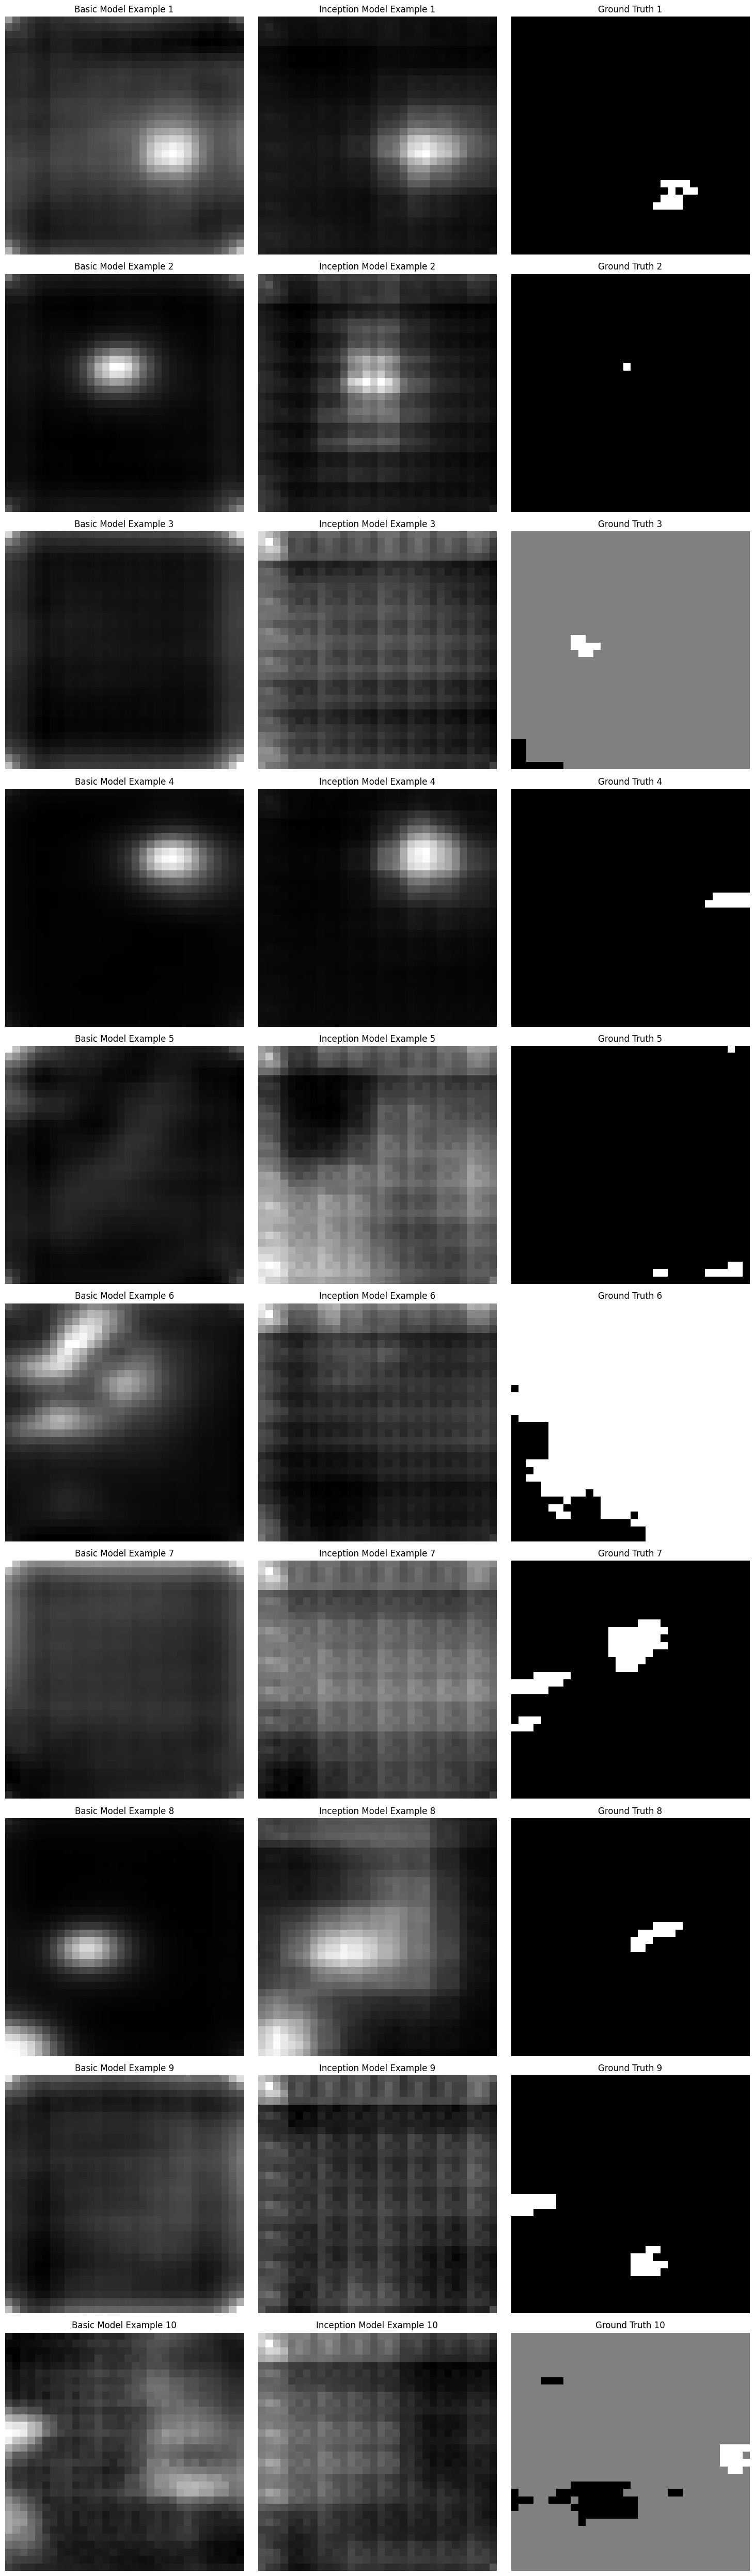

In [22]:
num_examples=10
plt.figure(figsize=(15, 5 * num_examples))

for idx, (inputs, ground_truth) in enumerate(test_dataset.take(num_examples)):
    # Predict using the model
    predicted_basic_image = top_models[0].predict(inputs)
    predicted_inception_image = top_inception_model[0].predict(inputs)

    # Input Image (Column 1)
    plt.subplot(num_examples, 3, idx * 3 + 1)
    plt.imshow(predicted_basic_image[0], cmap="gray")
    plt.title(f"Basic Model Example {idx+1}")
    plt.axis("off")

    # Predicted Image (Column 2)
    plt.subplot(num_examples, 3, idx * 3 + 2)
    plt.imshow(predicted_inception_image[0], cmap="gray")
    plt.title(f"Inception Model Example {idx+1}")
    plt.axis("off")

    # Ground Truth (Column 3)
    plt.subplot(num_examples, 3, idx * 3 + 3)
    plt.imshow(ground_truth[0], cmap="gray")
    plt.title(f"Ground Truth {idx+1}")
    plt.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()



